# Final model evaluation

Now the most important part: evaluating the model.


## Import standard libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
import time
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor

## Import custom scripts

In [4]:
import sys, os
sys.path.append(os.getcwd()+ "/../")
from src.data_preprocessing import DataPreprocessing

from src.compute_metrics import Metrics

## Load all the features
The datapreprocessing pipeline is doing quite some stuff, and in a non-efficient manner (I don't have much time for optimizing that :( )
But it should be less than 2 min

In [5]:
dp = DataPreprocessing(df_path = "../data/real_estate_ads_2022_10.csv",
                        train_indices_path="../data/train_indices.npy", 
                        test_indices_path="../data/test_indices.npy",
                        get_params_from_params=True,
                        get_tfidf_embeddings_flag=True,
                        get_bert_embeddings_flag=False, # IMPORTANT: WITHOUT BERT EMBEDDINGS
                        get_textual_features_flag=True,
                        transform_time_features_flag=True,
                        transform_cyclic_features_flag=True)

X_train, X_test = dp.get_train_test_split(dp.X)
y_train, y_test = dp.get_train_test_split(dp.Y)

## Load final model

In [6]:
import pickle as pkl

with open("../data/models/final_model_catboost.pkl", "rb") as f:
    model = pkl.load(f)

## Compute predictions

In [7]:
y_train_predict = pd.DataFrame(model.predict(X_train), columns=["price"])
y_test_predict = pd.DataFrame(model.predict(X_test), columns=["price"])

# and backward transform
y_train_predict = dp.backward_transform_price_per_m(y_train_predict)["price_per_m"]
y_test_predict = dp.backward_transform_price_per_m(y_test_predict)["price_per_m"]

y_test = dp.backward_transform_price_per_m(y_test)["price_per_m"]

## Get custom AUC plot

In [8]:
def percentage_of_errors_less_than_threshold_score(y_true, y_pred, threshold=20):

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    absolute_percentage_error = np.abs((y_true - y_pred) / y_true) * 100

    # now get the percentage of times that this lies below the threshold
    percentage_of_errors_less_than_threshold = (absolute_percentage_error < threshold).mean() * 100
    return percentage_of_errors_less_than_threshold

def custom_curve(y_true, y_pred, thresholds):
    percentage_of_errors = []
    for threshold in thresholds:
        percentage_of_errors.append(percentage_of_errors_less_than_threshold_score(y_true, y_pred, threshold))
    return percentage_of_errors

thresholds = np.arange(0, 101, 5)
percentages = custom_curve(y_test, y_test_predict, thresholds)

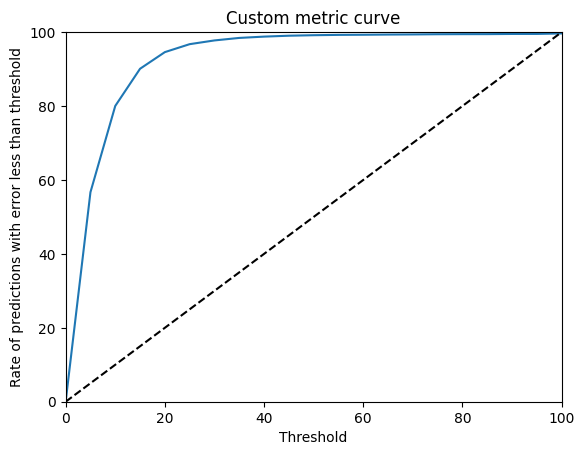

In [9]:
fig, ax = plt.subplots()
ax.plot(thresholds, percentages)
ax.set_xlabel("Threshold")
ax.set_ylabel("Rate of predictions with error less than threshold")
ax.set_title("Custom metric curve")
# Plot a diagonal line for reference
ax.plot(thresholds, thresholds, linestyle='--', color='black')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
plt.show()

## Compare with train curve

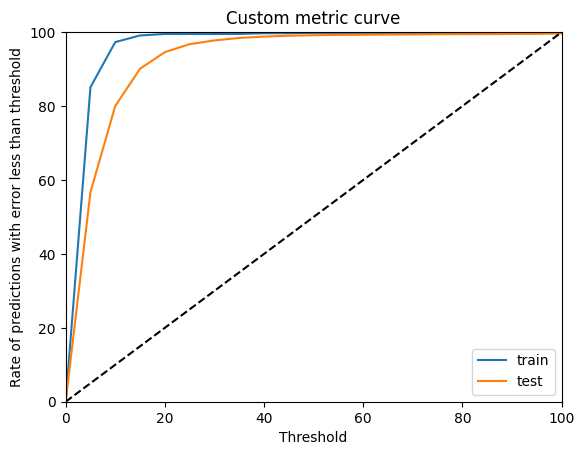

In [10]:
y_train = dp.backward_transform_price_per_m(y_train)["price_per_m"] # Forgot to do this before
# I am not doing well with managing memory, so avoiding just sampling)
percentages_train = custom_curve(y_train.sample(1000,random_state=1), 
                                 y_train_predict.sample(1000,random_state=1),
                                   thresholds)

fig, ax = plt.subplots()
ax.plot(thresholds, percentages_train, label="train")
ax.plot(thresholds, percentages, label="test")
ax.set_xlabel("Threshold")
ax.set_ylabel("Rate of predictions with error less than threshold")
ax.set_title("Custom metric curve")
# Plot a diagonal line for reference
ax.plot(thresholds, thresholds, linestyle='--', color='black')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
plt.legend()
plt.show()

# Only evaluate secondary market
We have trained on all data (primary and secondary markets). 

But the product is only for secondary market; so let's filter that out

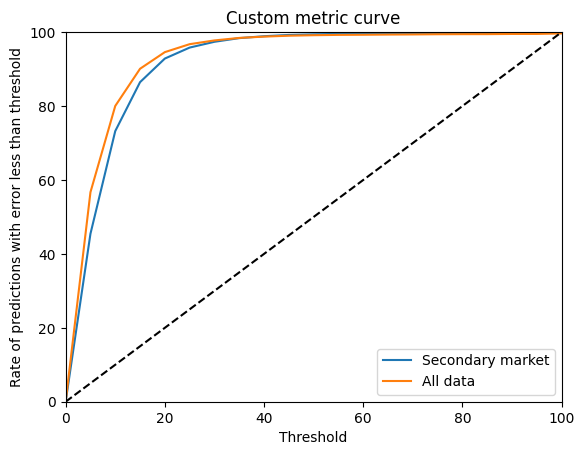

In [11]:
secondary_market_test_bool = (X_test["market_secondary"] == 1).values
y_test_secondary_market = y_test[secondary_market_test_bool]
y_test_predict_secondary_market = y_test_predict[secondary_market_test_bool]

percentages_secondary = custom_curve(y_test_secondary_market, y_test_predict_secondary_market,
                                   thresholds)

fig, ax = plt.subplots()
ax.plot(thresholds, percentages_secondary, label="Secondary market")
ax.plot(thresholds, percentages, label="All data")
ax.set_xlabel("Threshold")
ax.set_ylabel("Rate of predictions with error less than threshold")
ax.set_title("Custom metric curve")
# Plot a diagonal line for reference
ax.plot(thresholds, thresholds, linestyle='--', color='black')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
plt.legend()
plt.show()

In [12]:
custom_metric_1 = percentage_of_errors_less_than_threshold_score(y_test_secondary_market, y_test_predict_secondary_market, threshold=1)
custom_metric_5 = percentage_of_errors_less_than_threshold_score(y_test_secondary_market, y_test_predict_secondary_market, threshold=5)
custom_metric_10 = percentage_of_errors_less_than_threshold_score(y_test_secondary_market, y_test_predict_secondary_market, threshold=10)
custom_metric_20 = percentage_of_errors_less_than_threshold_score(y_test_secondary_market, y_test_predict_secondary_market, threshold=20)

custom_metric_1, custom_metric_5, custom_metric_10, custom_metric_20

(9.766963673749144, 45.44208361891707, 73.22366917980352, 92.84898332190998)

## Some explainability

In [13]:
import catboost as cb 
pool_train = cb.Pool(
    data=X_train,
    label=y_train,
    feature_names=X_train.columns.tolist()
)

pool_train_reduced = cb.Pool(
    data=X_train.sample(500, random_state=1),
    label=y_train.sample(500, random_state=1),
    feature_names=X_train.columns.tolist()
)

### For PredictionValuesChange

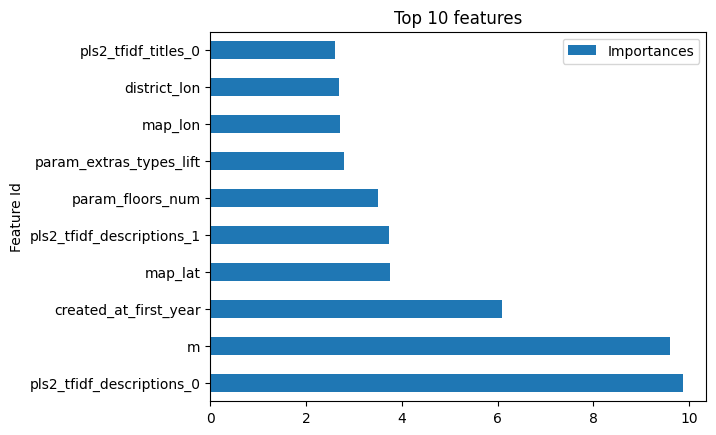

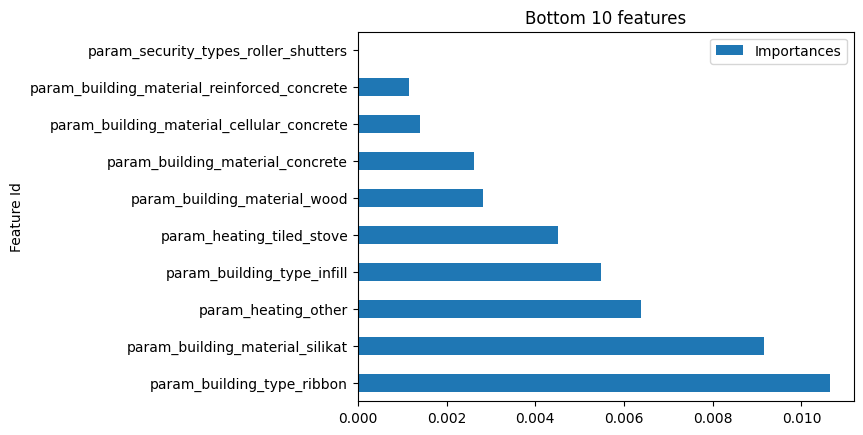

In [14]:
type_feature_importance = "PredictionValuesChange"

feature_importance = model.get_feature_importance(
    data=pool_train,
    type=type_feature_importance,
    prettified=True
).set_index("Feature Id")

feature_importance = feature_importance.sort_values(by="Importances", ascending=False)
# filter only the top 10 features
feature_importance_best = feature_importance.head(10)
# filter only the bottom 10 features
feature_importance_worst = feature_importance.tail(10)

fig, ax = plt.subplots()
feature_importance_best.plot(kind="barh", ax=ax)
ax.set_title("Top 10 features")
plt.show()

fig, ax = plt.subplots()
feature_importance_worst.plot(kind="barh", ax=ax)
ax.set_title("Bottom 10 features")
plt.show()

### For lossfunctionchange

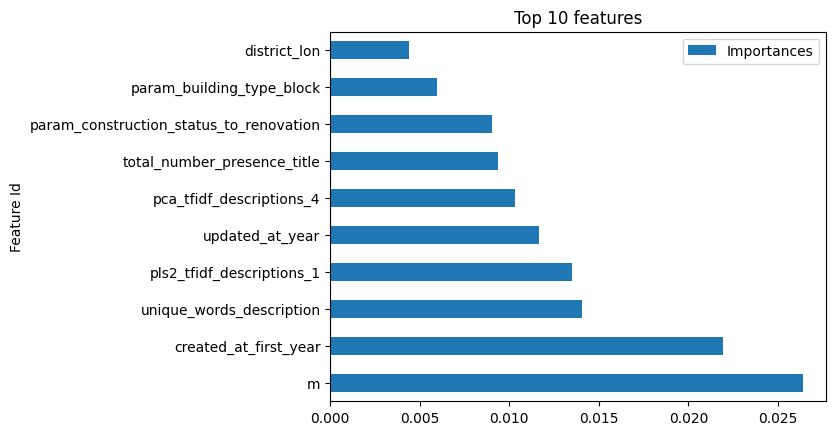

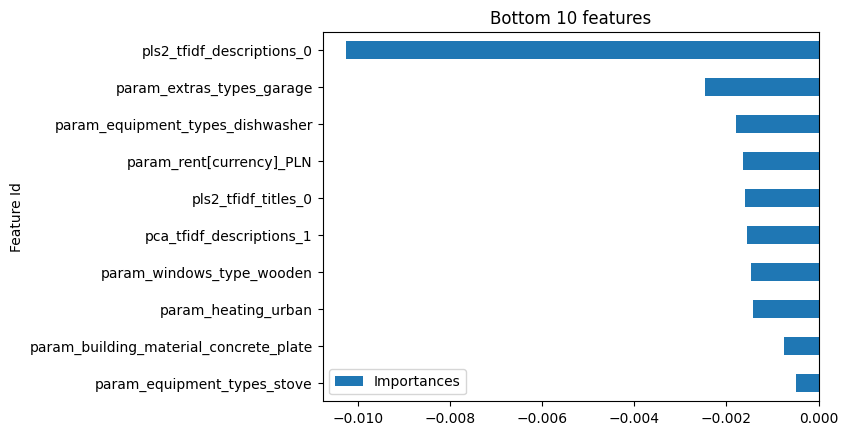

In [15]:
type_feature_importance = "LossFunctionChange"

feature_importance = model.get_feature_importance(
    data=pool_train_reduced,
    type=type_feature_importance,
    prettified=True
).set_index("Feature Id")

feature_importance = feature_importance.sort_values(by="Importances", ascending=False)
# filter only the top 10 features
feature_importance_best = feature_importance.head(10)
# filter only the bottom 10 features
feature_importance_worst = feature_importance.tail(10)

fig, ax = plt.subplots()
feature_importance_best.plot(kind="barh", ax=ax)
ax.set_title("Top 10 features")
plt.show()

fig, ax = plt.subplots()
feature_importance_worst.plot(kind="barh", ax=ax)
ax.set_title("Bottom 10 features")
plt.show()

### Shap values

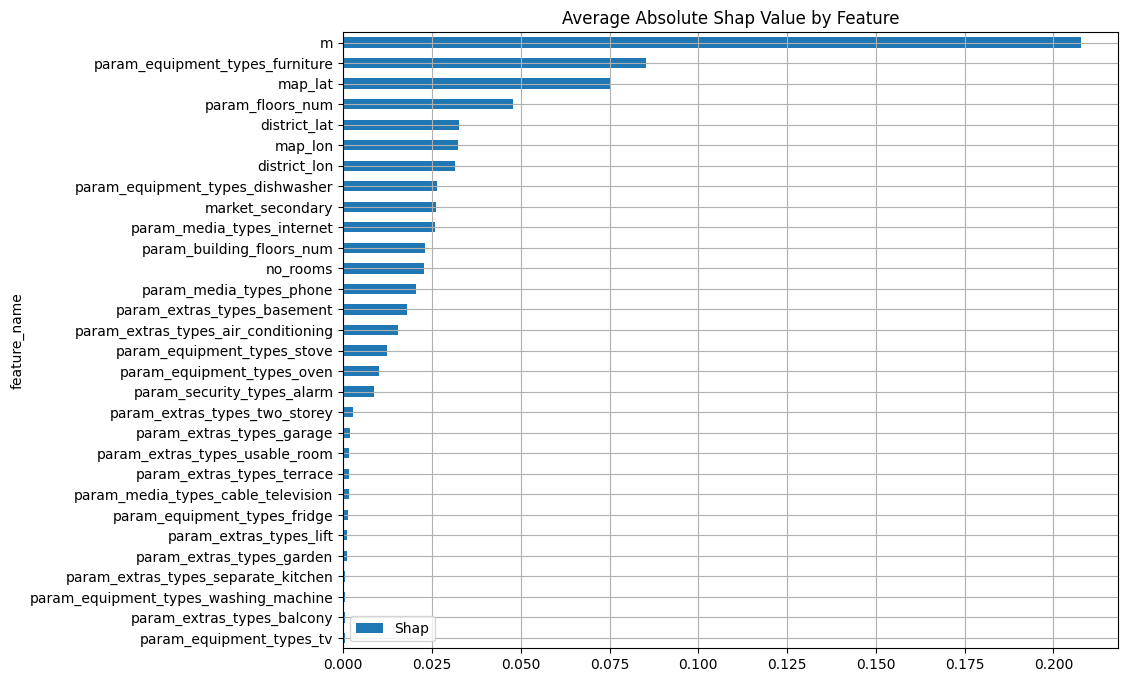

In [16]:
type_feature_importance = "ShapValues"

shap_values = model.get_feature_importance(
    data=pool_train_reduced,
    type=type_feature_importance,
    prettified=True
)

shap_values_sum = shap_values.abs().mean().to_frame("Shap")
shap_values_sum["feature_name"] = X_train.columns.tolist() + ["sum"]

shap_values_sum.loc[0:29]\
.set_index("feature_name").sort_values("Shap", ascending=True)\
.plot.barh(figsize=(10, 8), grid=True, title="Average Absolute Shap Value by Feature")
plt.show()

### Interactions

In [17]:
interactions = model.get_feature_importance(
    data=pool_train,
    type="Interaction",
    prettified=True
)

# Added the feature names for ease of checking
interactions["first_feature"] = interactions["First Feature Index"].apply(lambda x: X_train.columns.tolist()[x])
interactions["second_feature"] = interactions["Second Feature Index"].apply(lambda x: X_train.columns.tolist()[x])

interactions.head(10)

,First Feature Index,Second Feature Index,Interaction,first_feature,second_feature
0,3,74,0.893879,m,pls2_tfidf_descriptions_0
1,3,94,0.702170,m,duration_of_update
2,3,75,0.638198,m,pls2_tfidf_descriptions_1
3,3,5,0.581440,m,map_lat
4,3,4,0.526677,m,map_lon
5,3,88,0.519622,m,created_at_first_year
6,2,3,0.513829,no_rooms,m
7,3,69,0.510445,m,pca_tfidf_descriptions_0
8,3,67,0.483219,m,pls2_tfidf_titles_0
9,74,88,0.475387,pls2_tfidf_descriptions_0,created_at_first_year


## Understanding the error distribution
### Define plotting functions

In [28]:
import scipy.stats as stats

def plot_residuals(y_real, y_pred):

    residuals = y_real - y_pred

    # Creating a DataFrame for easier manipulation
    data = pd.DataFrame({
        'y_real': y_real,
        'y_pred': y_pred,
        'residuals': residuals
    })


    # Creating plots
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))

    # Residual Plot
    axs[0, 0].scatter(y_pred, residuals)
    axs[0, 0].axhline(0, color='red', linestyle='--')
    axs[0, 0].set_xlabel('Predicted Values')
    axs[0, 0].set_ylabel('Residuals')
    axs[0, 0].set_title('Residual Plot')

    # Histogram of Residuals
    axs[0, 1].hist(residuals, bins=20, edgecolor='k')
    axs[0, 1].set_xlabel('Residuals')
    axs[0, 1].set_ylabel('Frequency')
    axs[0, 1].set_title('Histogram of Residuals')

    # Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axs[1, 0])
    axs[1, 0].set_title('Q-Q Plot')

    # Scatter Plot of Predicted vs. Actual Values
    axs[1, 1].scatter(y_real, y_pred)
    axs[1, 1].plot([min(y_real), max(y_real)], [min(y_real), max(y_real)], color='red', linestyle='--')
    axs[1, 1].set_xlabel('Actual Values')
    axs[1, 1].set_ylabel('Predicted Values')
    axs[1, 1].set_title('Predicted vs. Actual Values')

    # Error vs. Predicted Value Plot
    axs[2, 0].scatter(y_pred, residuals)
    axs[2, 0].axhline(0, color='red', linestyle='--')
    axs[2, 0].set_xlabel('Predicted Values')
    axs[2, 0].set_ylabel('Residuals')
    axs[2, 0].set_title('Error vs. Predicted Value Plot')

    # CDF of Residuals
    sorted_residuals = np.sort(residuals)
    cdf = np.arange(len(residuals)) / float(len(residuals))
    axs[2, 1].plot(sorted_residuals, cdf)
    axs[2, 1].set_xlabel('Residuals')
    axs[2, 1].set_ylabel('CDF')
    axs[2, 1].set_title('Cumulative Distribution Function of Residuals')

    plt.tight_layout()
    plt.show()

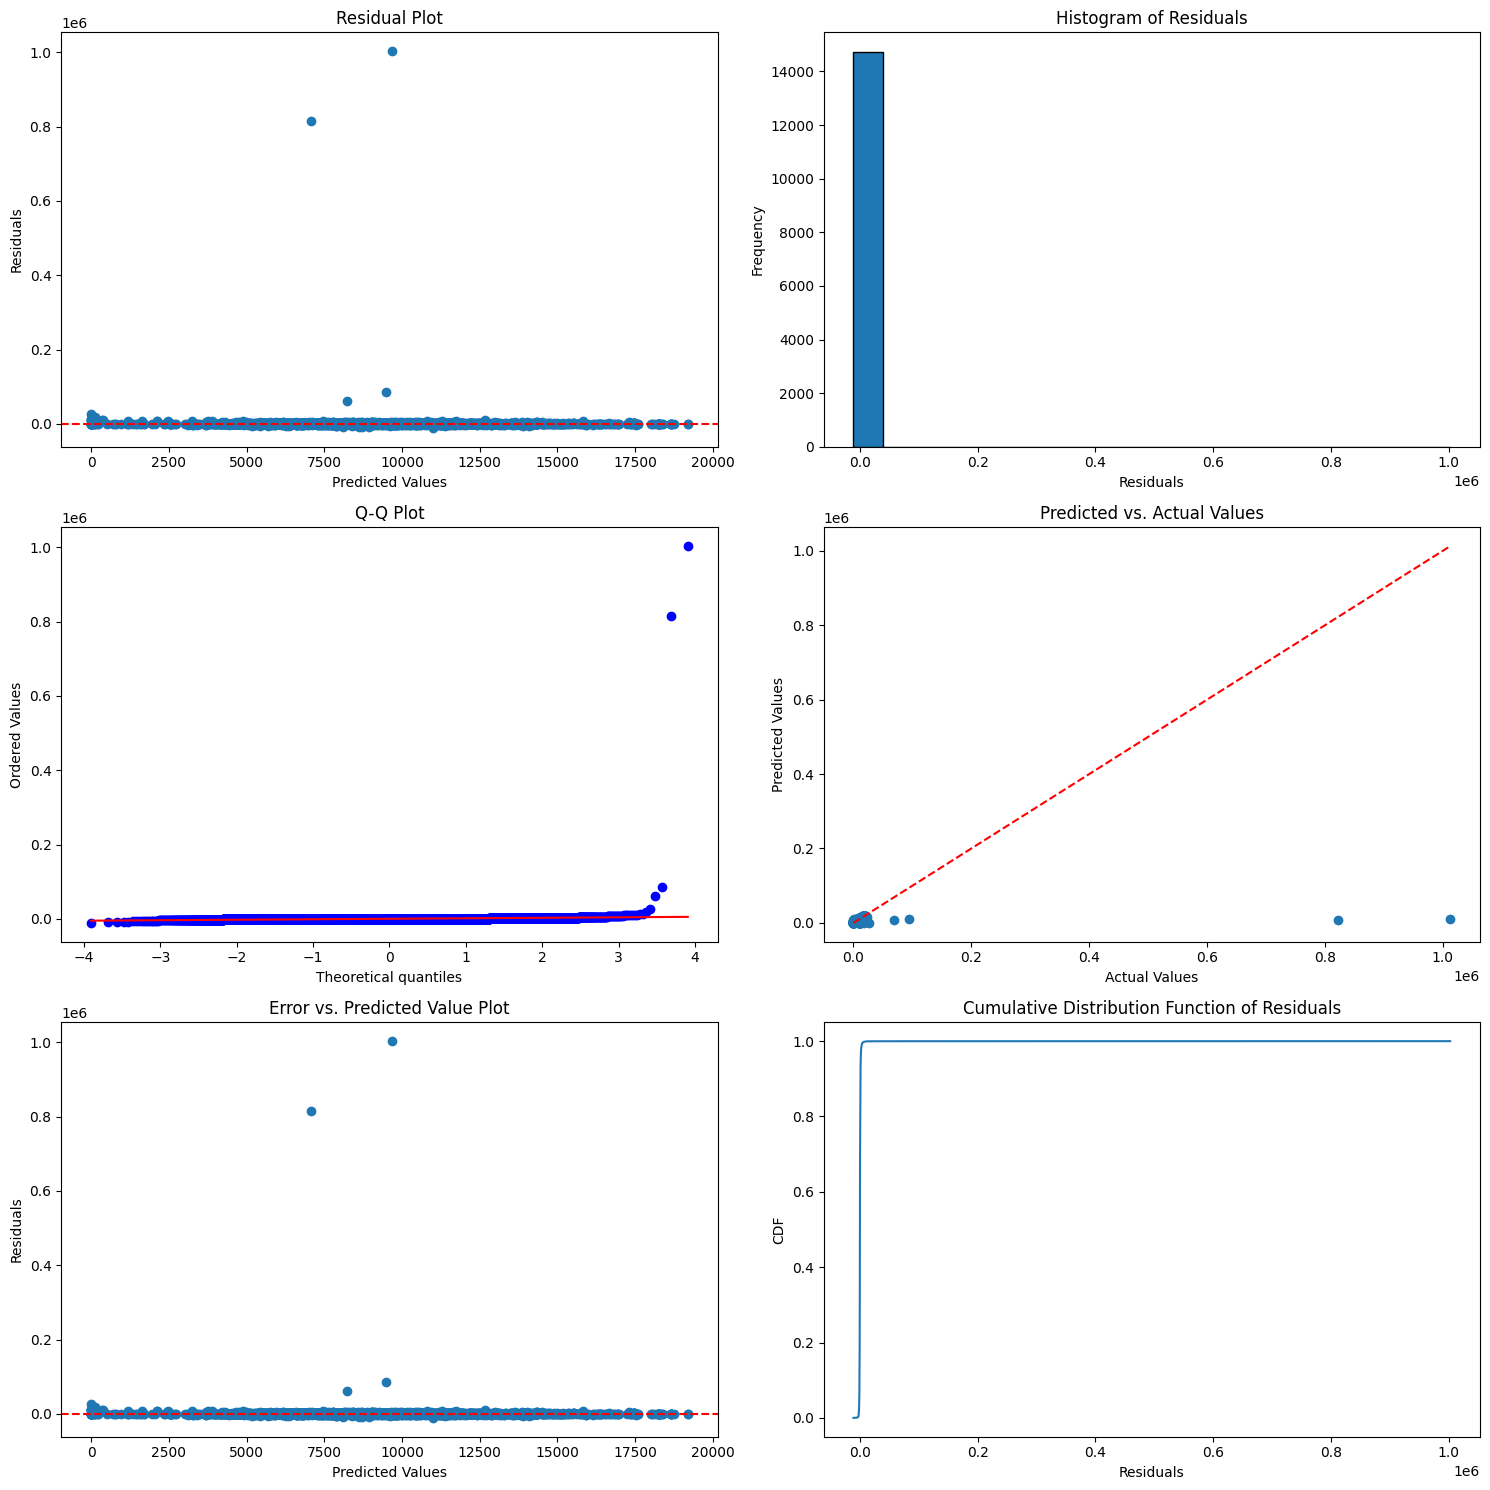

In [29]:
y_real = y_test.copy().values
y_pred = y_test_predict.copy().values

plot_residuals(y_real, y_pred)

We see that we have a lot of outliers distributions, that are affecting a lot the "standard" metrics.
## Remove outliers

We have removed 13 samples, which corresponds to 0.09% of the data


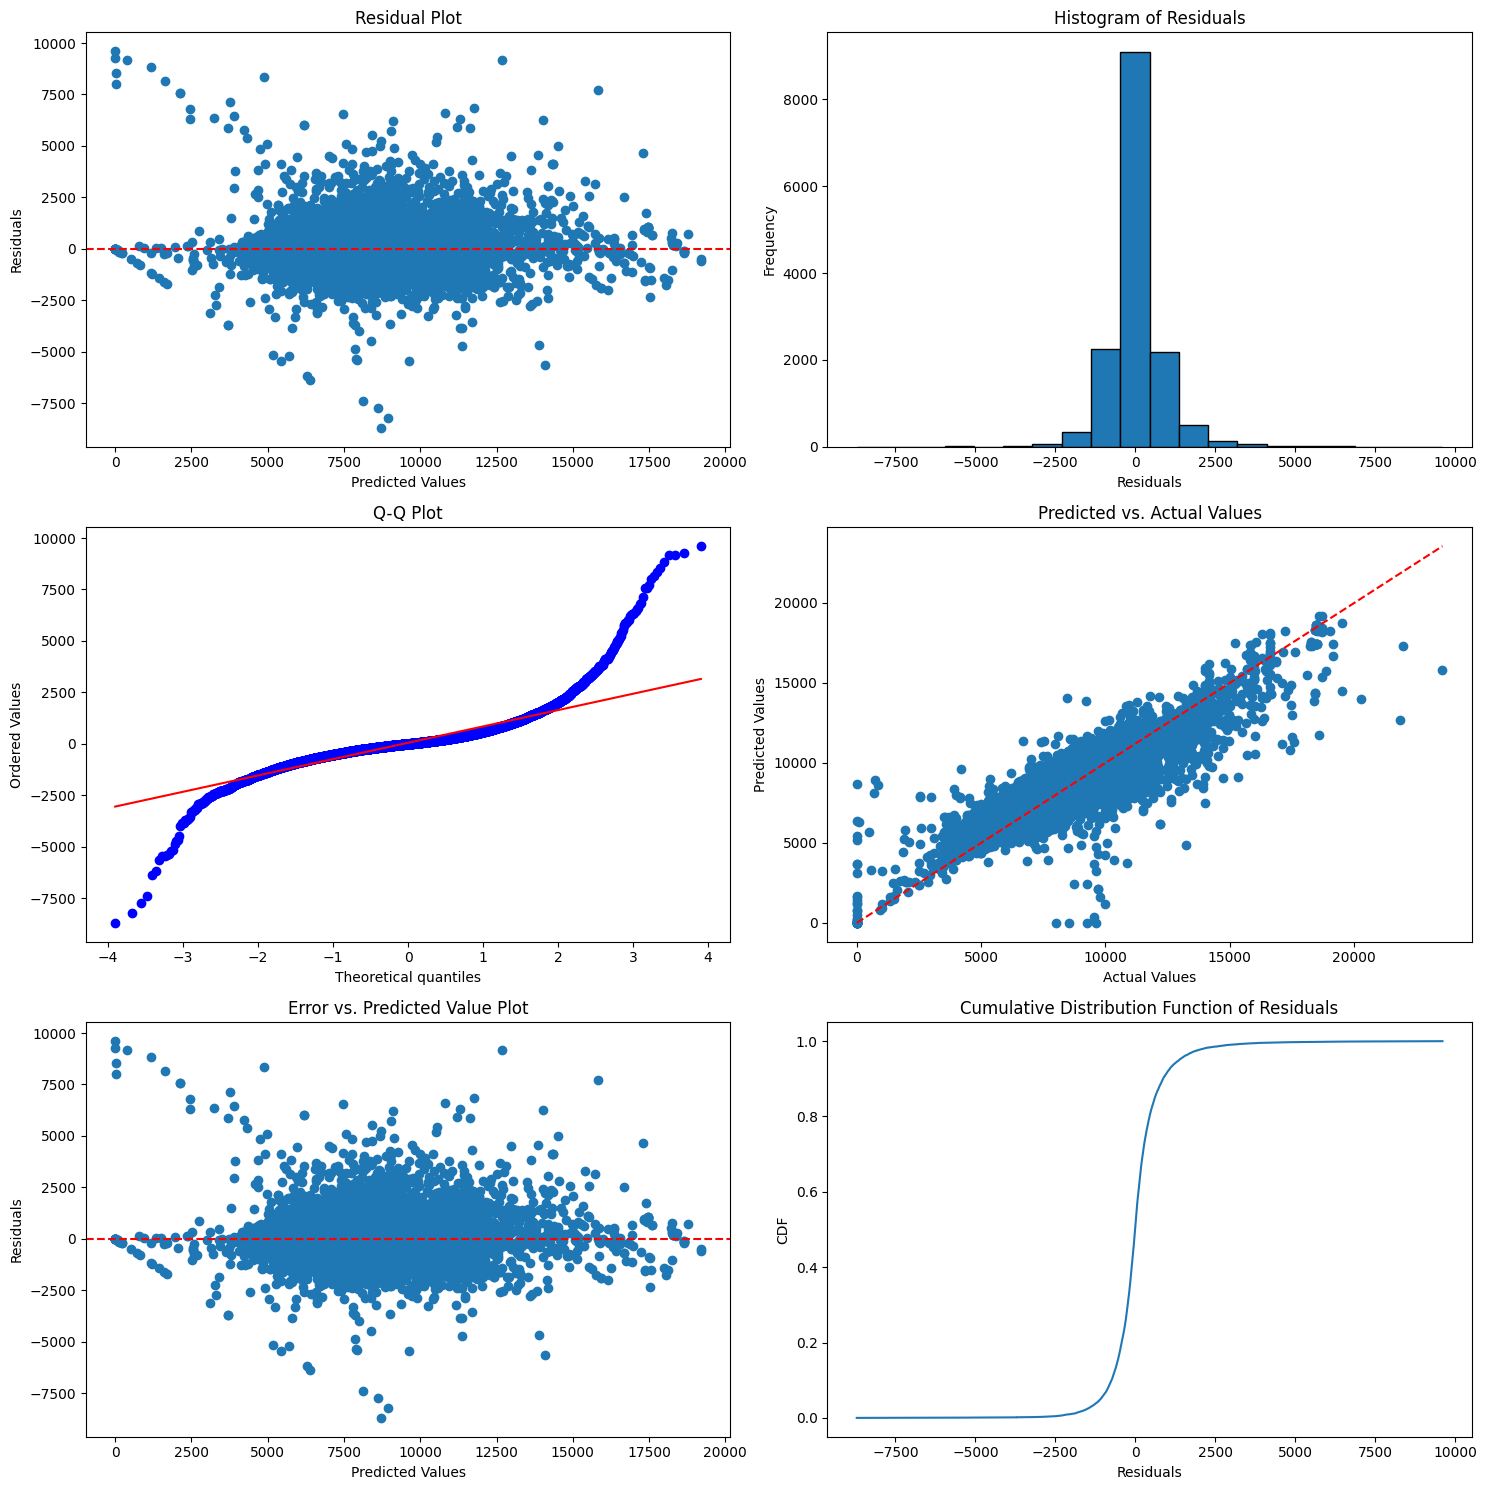

In [49]:
residuals = np.abs(y_pred - y_real)
residuals_are_not_too_big = residuals < 1e4
residuals_are_not_too_big = residuals_are_not_too_big

print(f"We have removed {len(residuals) - residuals_are_not_too_big.sum()} samples, which corresponds to {100 - residuals_are_not_too_big.mean() * 100:.2f}% of the data")

plot_residuals(y_real[residuals_are_not_too_big], y_pred[residuals_are_not_too_big])

## Re-evaluate the metrics with these corrections

In [57]:
from sklearn.metrics import (
    explained_variance_score,
    r2_score,
    mean_absolute_percentage_error,
    median_absolute_error,
    mean_absolute_error,
    mean_squared_log_error,
)

from src.compute_metrics import percentage_of_errors_less_than_threshold_score

def compute_metrics(y_true, y_pred):
    metrics = {
        "explained_variance_score": explained_variance_score(y_true, y_pred),
        "r2_score": r2_score(y_true, y_pred),
        "mean_absolute_percentage_error": mean_absolute_percentage_error(y_true, y_pred),
        "median_absolute_error": median_absolute_error(y_true, y_pred),
        "mean_absolute_error": mean_absolute_error(y_true, y_pred),
        "mean_squared_log_error": mean_squared_log_error(y_true, y_pred),
        "custom_1" : percentage_of_errors_less_than_threshold_score(y_true, y_pred, threshold=1),
        "custom_5" : percentage_of_errors_less_than_threshold_score(y_true, y_pred, threshold=5),
        "custom_10" : percentage_of_errors_less_than_threshold_score(y_true, y_pred, threshold=10),
        "custom_20" : percentage_of_errors_less_than_threshold_score(y_true, y_pred, threshold=20)
    }
    return metrics

computed_metrics_before = compute_metrics(y_real, y_pred)
computed_metrics_after = compute_metrics(y_real[residuals_are_not_too_big], y_pred[residuals_are_not_too_big])

## Make it a bit prettier

In [58]:

def highlight_max(s):
    is_max = s == s.replace("nan ± nan", "0").apply(lambda x: x.split("+-")[0]).max()
    return ['font-weight: bold' if v else '' for v in is_max]

def highlight_min(s):
    is_min = s == s.replace("nan ± nan", "0").apply(lambda x: x.split("+-")[0]).min()
    return ['font-weight: bold' if v else '' for v in is_min]

def format_results_df(results, column_names=None):
    results_df = pd.DataFrame(results).T

    if column_names is not None:
        results_df.columns = column_names
    
    def apply_highlight(column):
        if column.name in ["test_explained_variance", "test_r2", "test_custom_1", "test_custom_5", "test_custom_10", "test_custom_20"]:
            return highlight_max(column)
        else:
            return highlight_min(column)
    
    return results_df.style.apply(apply_highlight, axis=1)

### We see lot of improvement on the metrics, as expected

This is specially true for metrics not robust to outliers

In [64]:
df_results = pd.DataFrame({
    "before": computed_metrics_before,
    "after": computed_metrics_after
})

df_results

,before,after
explained_variance_score,0.029430,0.821412
r2_score,0.029133,0.820875
mean_absolute_percentage_error,118.569857,118.666336
median_absolute_error,320.926277,320.461940
mean_absolute_error,673.169114,532.088085
mean_squared_log_error,0.131914,0.101378
custom_1,15.764818,15.778744
custom_5,56.690882,56.740962
custom_10,80.025799,80.096494
custom_20,94.588906,94.672465


## Do this study a bit nicer

In [74]:
thresholds_absolute_errors_dict = {
    "1e10": 1e10,
    "1e8": 1e8,
    "1e6": 1e6,
    "1e4": 1e4,
    "1e2": 1e2,
    "1e1": 1e1,
}

metrics_dict = {}

for threshold_name in thresholds_absolute_errors_dict:

    threshold = thresholds_absolute_errors_dict[threshold_name]

    residuals_are_not_too_big = residuals < threshold
    metrics = compute_metrics(y_real[residuals_are_not_too_big], y_pred[residuals_are_not_too_big])

    metrics["percentage_of_samples"] = residuals_are_not_too_big.mean() * 100

    metrics_dict[threshold_name] = metrics

df_results = pd.DataFrame(metrics_dict)
df_results

,1e10,1e8,1e6,1e4,1e2,1e1
explained_variance_score,0.029430,0.029430,0.065625,0.821412,0.998747,0.999992
r2_score,0.029133,0.029133,0.065339,0.820875,0.998745,0.999992
mean_absolute_percentage_error,118.569857,118.569857,118.577840,118.666336,3.059326,2.959346
median_absolute_error,320.926277,320.926277,320.869410,320.461940,46.253999,4.768513
mean_absolute_error,673.169114,673.169114,605.132477,532.088085,47.514500,4.857196
mean_squared_log_error,0.131914,0.131914,0.130455,0.101378,0.019311,0.033199
custom_1,15.764818,15.764818,15.765888,15.778744,80.104895,95.731707
custom_5,56.690882,56.690882,56.694731,56.740962,99.405594,95.731707
custom_10,80.025799,80.025799,80.031233,80.096494,99.405594,95.731707
custom_20,94.588906,94.588906,94.595329,94.672465,99.405594,95.731707


## Try out some (maybe) interesting plots

In [108]:
thresholds_absolute_error_dict_extended = {str(threshold): threshold for threshold in np.linspace(1, 5, num=20)**10}

metrics_dict = {}

for threshold_name in thresholds_absolute_error_dict_extended:

    threshold = thresholds_absolute_error_dict_extended[threshold_name]

    residuals_are_not_too_big = residuals < threshold
    metrics = compute_metrics(y_real[residuals_are_not_too_big], y_pred[residuals_are_not_too_big])

    metrics["percentage_of_samples"] = residuals_are_not_too_big.mean() * 100

    metrics_dict[threshold_name] = metrics

In [109]:
# plot different scores wrt the threshold

df_results = pd.DataFrame(metrics_dict)

def plot_metrics_vs_threshold(df_results, metrics_names, title):
    fig, ax = plt.subplots()
    for metric_name in metrics_names:
        ax.plot(df_results.columns, df_results.loc[metric_name], label=metric_name)
    ax.set_xscale("log")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.legend()
    plt.show()

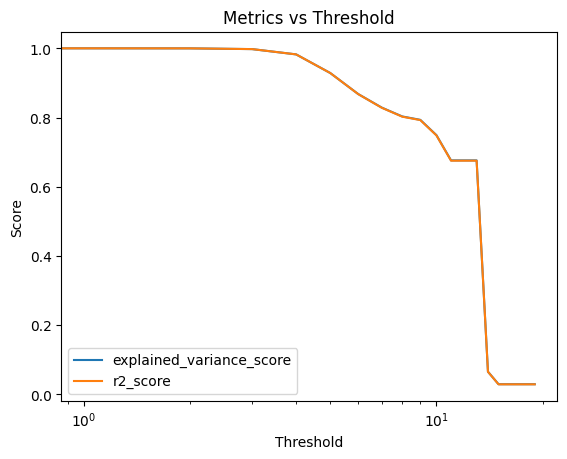

In [110]:
plot_metrics_vs_threshold(df_results, ["explained_variance_score", "r2_score"], "Metrics vs Threshold")

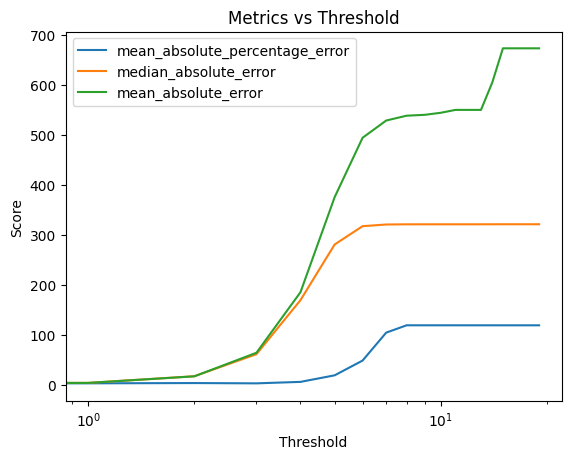

In [111]:
plot_metrics_vs_threshold(df_results, ["mean_absolute_percentage_error", "median_absolute_error", "mean_absolute_error"], "Metrics vs Threshold")

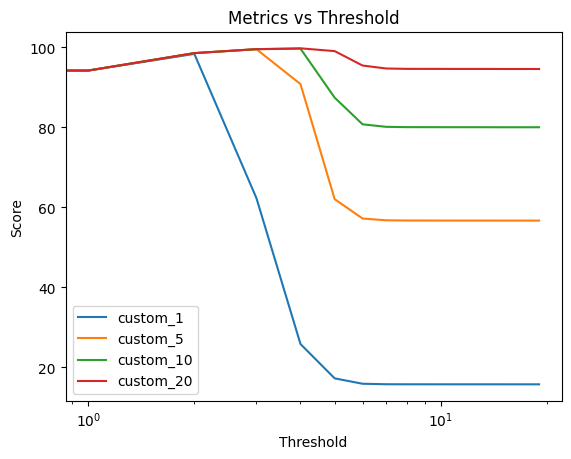

In [112]:
plot_metrics_vs_threshold(df_results, ["custom_1", "custom_5", "custom_10", "custom_20"], "Metrics vs Threshold")

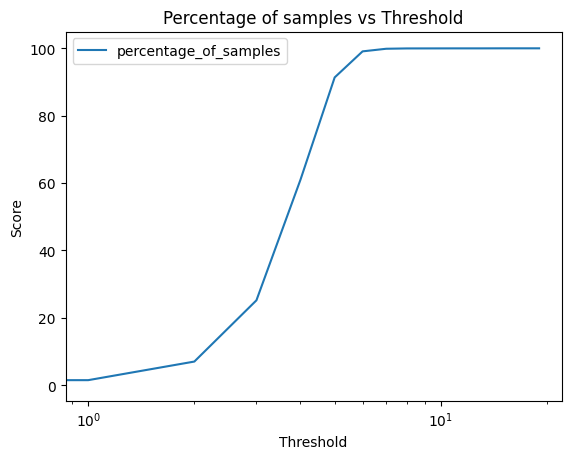

In [114]:
plot_metrics_vs_threshold(df_results, ["percentage_of_samples"], "Percentage of samples vs Threshold")